<a href="https://colab.research.google.com/github/awaisnazir08/GANs_Anime_Faces_Generation/blob/main/Anime_faces_generation_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import os
from re import I
import math
import time
import opendatasets as od
from PIL import Image
import cv2

In [26]:
PROJECT_NAME = 'anime_faces_generation'
DATASET_URL = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
DATASET_DIR = '/content/animefacedataset'
IMAGE_DIR = '/content/animefacedataset/images'
SAMPLE_DIR = '/content/generated'
BATCH_SIZE = 128
IMAGE_SIZE = 64
LEARNING_RATE = 0.0002
EPOCHS = 50
LATENT_SIZE = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


In [4]:
od.download(DATASET_URL)

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:03<00:00, 125MB/s]


In [5]:
images = os.listdir(IMAGE_DIR)

In [27]:
def display_images(images, IMAGES_DIR = '/content/animefacedataset/images'):
  for image in images:
    image = os.path.join(IMAGES_DIR, image)
    image = Image.open(image)
    plt.axis('off')
    plt.imshow(image)
    plt.show()


In [28]:
def denormalize(image_tensors):
    return image_tensors * stats[1][0] + stats[0][0]


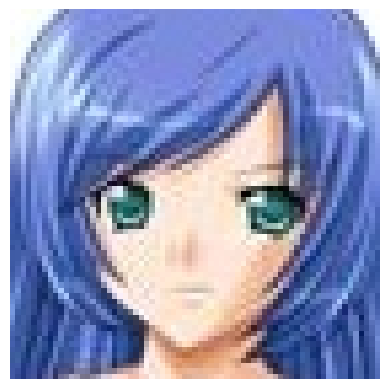

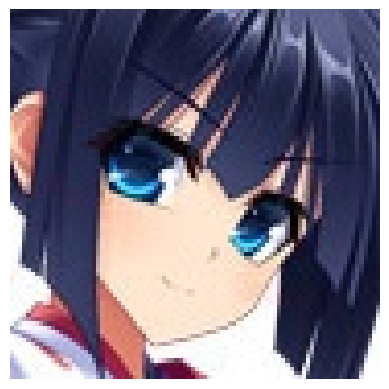

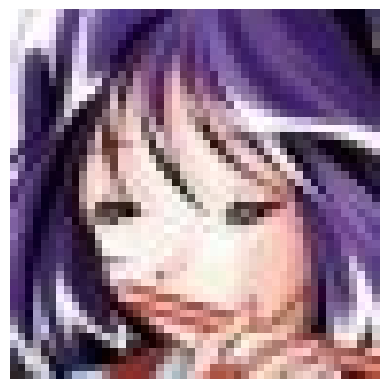

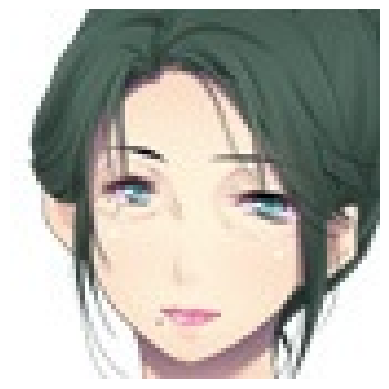

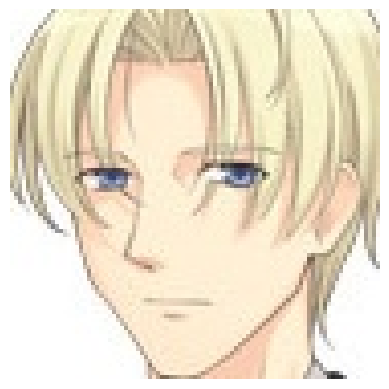

In [8]:
display_images(images[:5])

In [29]:
image = os.path.join(IMAGE_DIR, images[5])
image = Image.open(image)
image = np.array(image)
image.shape

(94, 94, 3)

In [30]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [31]:
train_dataset = datasets.ImageFolder(DATASET_DIR, transform=transform)

In [32]:
data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 2, pin_memory=True)

In [33]:
print(stats[1][0])

0.5


In [34]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

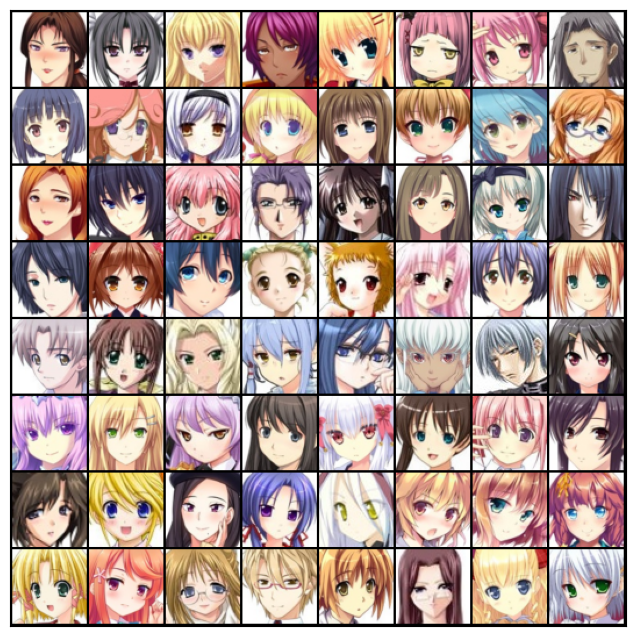

In [35]:
show_batch(data_loader)

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cuda')

In [38]:
data_loader = DeviceDataLoader(data_loader, device)

In [39]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [40]:
discriminator = to_device(discriminator, device)

In [41]:
generator = nn.Sequential(
    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


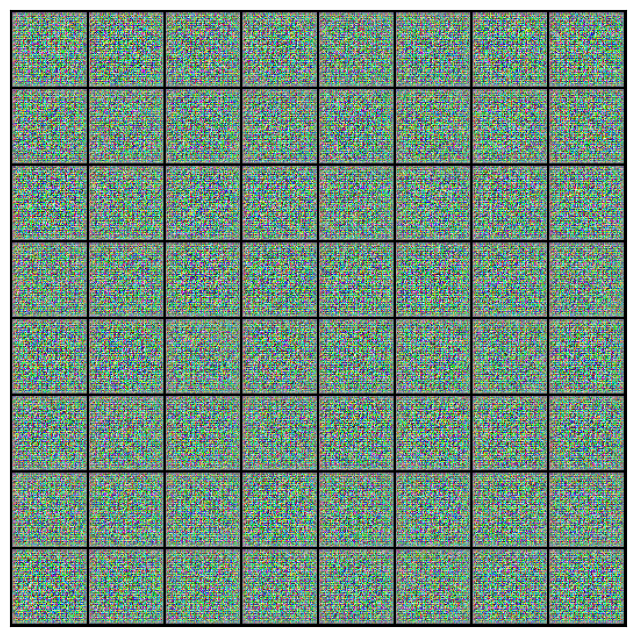

In [42]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)
gen_sample = generator(xb)
print(gen_sample.shape)
show_images(gen_sample)

In [43]:
generator = to_device(generator, device)

In [44]:
def train_discriminator(real_images, optimizer):
  optimizer.zero_grad()
  real_predictions = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device = device)
  real_loss = F.binary_cross_entropy(real_predictions, real_targets)
  real_score = torch.mean(real_predictions).item()

  latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device = device)
  fake_images = generator(latent)

  fake_predictions = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
  fake_loss = F.binary_cross_entropy(fake_predictions, fake_targets)
  fake_score = torch.mean(fake_predictions).item()

  loss = real_loss + fake_loss
  loss.backward()
  optimizer.step()

  return loss.item(), real_score, fake_score


In [45]:
def train_generator(optimizer):
  optimizer.zero_grad()
  latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device = device)
  fake_images = generator(latent)
  predictions = discriminator(fake_images)
  targets = torch.ones(BATCH_SIZE, 1, device = device)
  loss = F.binary_cross_entropy(predictions, targets)

  loss.backward()
  optimizer.step()
  return loss.item()


In [46]:
os.makedirs(SAMPLE_DIR, exist_ok = True)

In [47]:
def save_samples(index, latent_tensors, show = True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denormalize(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow = 8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [48]:
random_noise = torch.randn(64, LATENT_SIZE, 1, 1, device=device)

Saving generated-images-0000.png


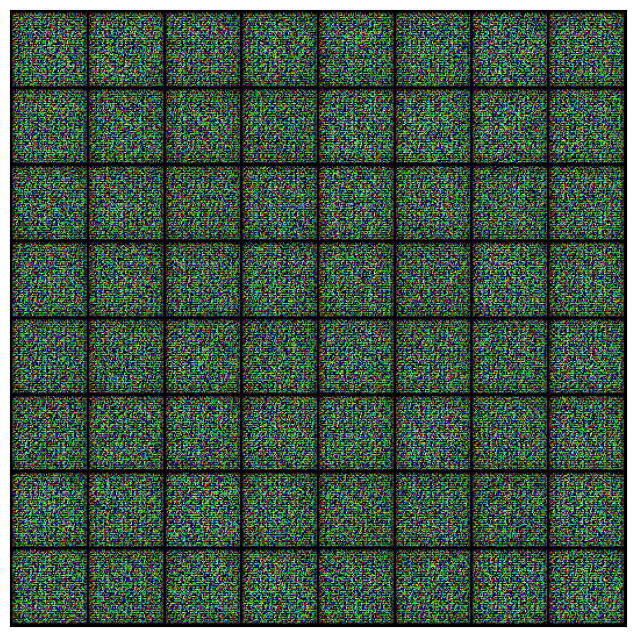

In [49]:
save_samples(0, random_noise)


In [50]:
def fit(start_idx=1):
  torch.cuda.empty_cache()

  losses_generator = []
  losses_discriminator = []

  real_scores = []
  fake_scores = []

  optimizer_generator = optim.Adam(generator.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
  optimizer_discriminator = optim.Adam(discriminator.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))

  start = time.time()
  for epoch in range(EPOCHS):
    for real_images, _ in tqdm(data_loader):
      loss_discriminator, real_score, fake_score = train_discriminator(real_images, optimizer_discriminator)
      loss_generator = train_generator(optimizer_generator)
      losses_generator.append(loss_generator)
      losses_discriminator.append(loss_discriminator)
      real_scores.append(real_score)
      fake_scores.append(fake_score)

  # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_generator: {:.4f}, loss_discriminator: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, EPOCHS, loss_generator, loss_discriminator, real_score, fake_score))

    # Save generated images
    save_samples(epoch+start_idx, random_noise, show=True)

  return losses_generator, losses_discriminator, real_scores, fake_scores

In [ ]:
history = fit()

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/50], loss_generator: 3.2876, loss_discriminator: 0.1389, real_score: 0.9068, fake_score: 0.0244
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_generator: 9.0077, loss_discriminator: 0.7770, real_score: 0.9190, fake_score: 0.4427
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_generator: 5.9199, loss_discriminator: 0.2090, real_score: 0.9257, fake_score: 0.1093
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_generator: 5.5387, loss_discriminator: 0.1936, real_score: 0.9804, fake_score: 0.1415
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_generator: 6.5275, loss_discriminator: 0.1350, real_score: 0.9673, fake_score: 0.0922
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_generator: 6.4129, loss_discriminator: 0.1007, real_score: 0.9368, fake_score: 0.0153
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_generator: 4.6273, loss_discriminator: 0.0872, real_score: 0.9407, fake_score: 0.0158
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_generator: 5.9419, loss_discriminator: 0.0783, real_score: 0.9734, fake_score: 0.0479
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_generator: 6.6454, loss_discriminator: 0.1075, real_score: 0.9736, fake_score: 0.0736
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'Generator.pth')
torch.save(discriminator.state_dict(), 'Discriminator.pth')

In [ ]:
generated_images = os.listdir(SAMPLE_DIR)
display_images(generated_images, SAMPLE_DIR)

In [ ]:
vid_fname = 'gans_training.avi'

files = [os.path.join(SAMPLE_DIR, f) for f in os.listdir(SAMPLE_DIR) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');